In [6]:
from load import *
from utils import *
from IPython.display import *
import pickle
import cv2
import time
import os
import base64
import json

In [7]:
#! conda install opencv

## Data Processing

In [8]:
# replace with local path to Charades and ActionGenome annotations and videos
csv_dir = "../annotations/"  # Charades annotations
annotation_dir = '../annotations/'  # object_bbox_and_relationship.pkl
video_dir = '../label_tool/static/mp4/Charades_v1_480/'  # videos
fps_path = 'fps'

data = load_csv(csv_dir)
mapping = load_mapping(csv_dir)
obj_map = load_obj_mapping(csv_dir)
verb_map = load_verb_mapping(csv_dir)
data = extract_actions(data)  # key: video id, value: (action list, video length, script)
fps_file = open(fps_path, 'rb')
fps = pickle.load(fps_file)
with open('../label_tool/qa.json', 'r') as f:
    QAList = json.load(f)

In [19]:
# 50N4E.mp4
anno_video_split = {}  # key: video id, value: relationship annotations
frame_object_anno = load_annotations(annotation_dir)

for k in frame_object_anno.keys():
    s = k.split('/')
    video_id = s[0].split('.')[0]
    frame_id = s[1].split('.')[0]
#     print(video_id, frame_id)
    if video_id in anno_video_split:
        anno_video_split[video_id][frame_id] = frame_object_anno[k]
    else:
        anno_video_split[video_id] = {frame_id: frame_object_anno[k]}

## Search Functions

In [5]:
def filter_action(action_list):
    videos = []
    for each in data.keys():
        action_not_found = False
        for each_target_action in action_list:
            found = False
            # print(data[each])
            for each_action in data[each][0]:
                if each_target_action == each_action[0]:
                    found = True
                    break
            if not found:
                action_not_found = True
                break
        if not action_not_found:
            videos.append(each)
    return videos

def filter_verb(verb_list):
    videos = []
    for each in data.keys():
        action_not_found = False
        for each_target_verb in verb_list:
            found = False
            for each_action in data[each][0]:
                if each_target_verb == verb_map[each_action[0]]:
                    found = True
                    break
            if not found:
                action_not_found = True
                break
        if not action_not_found:
            videos.append(each)
    return videos

def filter_relationship(rel_list):
    videos = []
    for each in data.keys():
        relationship_list = []
        if not anno_video_split.__contains__(each):
            continue
        annotation = anno_video_split[each]
        for frame in annotation.keys():
            for i in range(len(annotation[frame])):
                if annotation[frame][i]['attention_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['attention_relationship']:
                        relationship_list.append(each_relationship + "," + annotation[frame][i]['class'])
                if annotation[frame][i]['spatial_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['spatial_relationship']:
                        relationship_list.append(each_relationship + "," + annotation[frame][i]['class'])
                if annotation[frame][i]['contacting_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['contacting_relationship']:
                        relationship_list.append(each_relationship + "," + annotation[frame][i]['class'])
        
        rel_not_found = False
        for each_target_rel in rel_list:
            found = False
            for each_rel in relationship_list:
                if each_target_rel == each_rel:
                    found = True
                    break
            if not found:
                rel_not_found = True
                break
        if not rel_not_found:
            videos.append(each)
    return videos

def filter_all(action_list, verb_list, rel_list):
    videos = []
    for each in data.keys():
        action_not_found = False
        for each_target_action in action_list:
            found = False
            # print(data[each])
            for each_action in data[each][0]:
                if each_target_action == each_action[0]:
                    found = True
                    break
            if not found:
                action_not_found = True
                break
        if not action_not_found:
            videos.append(each)
            
    videos1 = []
    for each in videos:
        action_not_found = False
        for each_target_verb in verb_list:
            found = False
            for each_action in data[each][0]:
                if each_target_verb == verb_map[each_action[0]]:
                    found = True
                    break
            if not found:
                action_not_found = True
                break
        if not action_not_found:
            videos1.append(each)
            
    videos2 = []
    for each in videos1:
        relationship_list = []
        if not anno_video_split.__contains__(each):
            continue
        annotation = anno_video_split[each]
        for frame in annotation.keys():
            for i in range(len(annotation[frame])):
                if annotation[frame][i]['attention_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['attention_relationship']:
                        relationship_list.append(each_relationship + "," + annotation[frame][i]['class'])
                if annotation[frame][i]['spatial_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['spatial_relationship']:
                        relationship_list.append(each_relationship + "," + annotation[frame][i]['class'])
                if annotation[frame][i]['contacting_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['contacting_relationship']:
                        relationship_list.append(each_relationship + "," + annotation[frame][i]['class'])
        
        rel_not_found = False
        for each_target_rel in rel_list:
            found = False
            for each_rel in relationship_list:
                if each_target_rel == each_rel:
                    found = True
                    break
            if not found:
                rel_not_found = True
                break
        if not rel_not_found:
            videos2.append(each)
    return videos2

## Classe Keywords

In [6]:
# video scene (action) distribution
# action classes (verb) distribution
# object classes distribution


## Search by Keywords

In [7]:
action_list = ['c000']  # filter by actions (id): the filtered videos should contain all these actions
verb_list = ['take']  # filter by verbs: the filtered videos should contain all these verbs
relationship_list = ['looking_at,shoe']  # filter by relationships: the filtered videos should contain all these relationships;
                                         # format: "rel,obj"; e.g. "in_front_of,mirror"
filter_by = 'all'  # 'action', 'verb', 'relationship', 'all'

if filter_by == 'action':
    filtered_videos = filter_action(action_list)
elif filter_by == 'verb':
    filtered_videos = filter_verb(verb_list)
elif filter_by == 'relationship':
    filtered_videos = filter_relationship(relationship_list)
elif filter_by == 'all':
    filtered_videos = filter_all(action_list, verb_list, relationship_list)
    
video_paths = [video_dir + video_id + '.mp4' for video_id in filtered_videos]
print(str(len(video_paths)) + " video(s) found")
video_paths[:10]

38 video(s) found


['../label_tool/static/mp4/Charades_v1_480/SYMIR.mp4',
 '../label_tool/static/mp4/Charades_v1_480/29LL7.mp4',
 '../label_tool/static/mp4/Charades_v1_480/AZZ3W.mp4',
 '../label_tool/static/mp4/Charades_v1_480/4D5XD.mp4',
 '../label_tool/static/mp4/Charades_v1_480/FSWT4.mp4',
 '../label_tool/static/mp4/Charades_v1_480/VXM6A.mp4',
 '../label_tool/static/mp4/Charades_v1_480/TW12W.mp4',
 '../label_tool/static/mp4/Charades_v1_480/JC1DV.mp4',
 '../label_tool/static/mp4/Charades_v1_480/UR7C8.mp4',
 '../label_tool/static/mp4/Charades_v1_480/4NRPM.mp4']

## Program Visualization

In [18]:
# As each video has different questions, displaying all the QA pairs and programs would take up too much space.
# For remedy, the QIDs are provided. Refer to labeling tool to check the programs.

# display the videos
from IPython.display import Video
k = 0
print(video_paths[k])
v = video_paths[k].split('/')[-1].split('.')[0]
print("Video ID: " + v)
print("Description: " + data[v][2])

start_QID = -1
end_QID = -1
flag = False
for each_QA in QAList:
    if not flag:
        if each_QA['video_id'] == v:
            start_QID = each_QA['question_index']
            flag = True
    else:
        if each_QA['video_id'] != v:
            end_QID = each_QA['question_index'] - 1
            break
print("Question ID: " + str(start_QID) + ' to ' + str(end_QID))
print("Actions:")
for each_action in data[v][0]:
    print('\t ' + each_action[1] + '-' + each_action[2] + ': ' + mapping[each_action[0]])
#         print('\t' + mapping[each_action[0]] )
print("Verbs:")
verb_set = set()
for each_action in data[v][0]:
    verb_set.add(verb_map[each_action[0]])
for verb in list(verb_set):
    print('\t' + verb)
print("Objects:")
obj_set = set()
for each_action in data[v][0]:
    obj_set.add(obj_map[each_action[0]])
for o in list(obj_set):
    print('\t' + o)
print("Relationships:")
annotation = anno_video_split[v]
relationship_list = set()
for frame in annotation.keys():
    for i in range(len(annotation[frame])):
        if annotation[frame][i]['attention_relationship'] is not None:
            for each_relationship in annotation[frame][i]['attention_relationship']:
                relationship_list.add(each_relationship + " - " + annotation[frame][i]['class'])
        if annotation[frame][i]['spatial_relationship'] is not None:
            for each_relationship in annotation[frame][i]['spatial_relationship']:
                relationship_list.add(each_relationship + " - " + annotation[frame][i]['class'])
        if annotation[frame][i]['contacting_relationship'] is not None:
            for each_relationship in annotation[frame][i]['contacting_relationship']:
                relationship_list.add(each_relationship + " - " + annotation[frame][i]['class'])
for each_rel in list(relationship_list):
    print('\t' + each_rel)
print('--------- \n')
Video(video_paths[k])

../label_tool/static/mp4/Charades_v1_480/SYMIR.mp4
Video ID: SYMIR
Description: A person is standing in the hall undressing after work, taking off their shoes and jacket. This person places the shoes on a nearby towel.
Question ID: 438 to 446
Actions:
	 0.00-4.80: open a door
	 0.10-7.10: walk through a doorway
	 0.30-7.80: grasp onto a doorknob
	 1.20-7.00: close a door
	 12.90-33.00: take off some shoes
	 16.10-31.80: take shoes from somewhere
	 17.70-31.10: throw something on the floor
	 25.60-32.50: stand up from somewhere
	 5.30-14.60: undress
	 6.20-13.50: take some clothes from somewhere
	 9.30-15.30: hold some clothes
	 9.30-15.30: put clothes somewhere
Verbs:
	close
	put
	undress
	grasp
	open
	take
	walk
	hold
	stand
	throw
Objects:
	floor
	door
	doorknob
	None
	clothes
	shoe
	doorway
Relationships:
	on_the_side_of - door
	not_looking_at - doorway
	beneath - shoe
	holding - clothes
	not_contacting - door
	touching - doorknob
	looking_at - shoe
	behind - clothes
	touching - doo

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [40]:
def get_relationships(video_id, start_frame, end_frame):
    annotation = anno_video_split[video_id]
    relationship_list = set()
    for frame in annotation.keys():
        if start_frame <= int(frame) <= end_frame:
            for i in range(len(annotation[frame])):
                if annotation[frame][i]['attention_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['attention_relationship']:
                        relationship_list.add((frame, each_relationship + " - " + annotation[frame][i]['class']))
                if annotation[frame][i]['spatial_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['spatial_relationship']:
                        relationship_list.add((frame, each_relationship + " - " + annotation[frame][i]['class']))
                if annotation[frame][i]['contacting_relationship'] is not None:
                    for each_relationship in annotation[frame][i]['contacting_relationship']:
                        relationship_list.add((frame, each_relationship + " - " + annotation[frame][i]['class']))
    relationship_list = list(relationship_list)
    relationship_list = sorted(relationship_list, key=lambda x: x[0])
    return list(relationship_list)

In [42]:
# Query by QID
QID = 626
for each in QAList:
    if each['question_index'] == QID:
        VID = str(each['video_id'])
        print('Video ID: ' + VID)
        print('Question:\n\t' + each['question'])
        print('Choices:')
        for c in each['choices']:
            print('\t' + c['choice'])
        print('Program:')
        print(each['program'])
        print('Relationships:')
        for each_rel in get_relationships(VID, each['start'] * fps[VID+".mp4"], each['end'] * fps[VID+".mp4"]):
            print('\t' + str(int(each_rel[0]) / fps[VID+".mp4"])[:5] + '\t' + each_rel[1])  # time, relationship
        break

Video ID: VJ3B5
Question:
	What should the person do in order to take a box from somewhere? 
Choices:
	throw something on the floor. 
	throw a box somewhere. 
	None of the above makes sense. 
Program:
Get_rank(
	[a], 
	filter_end_states(
		filter_before(
			take a box from somewhere, 
			all_actions
		), 
		get_start_states(take a box from somewhere)
	)
)
Relationships:
	5.633	not_contacting - box
	5.633	looking_at - box
	5.633	in_front_of - box
	5.733	not_contacting - box
	5.733	looking_at - box
	5.733	in_front_of - box
	6.466	not_contacting - box
	6.466	looking_at - box
	6.466	in_front_of - box
	6.633	looking_at - box
	6.633	not_contacting - box
	6.633	in_front_of - box
	6.7	in_front_of - box
	6.7	looking_at - box
	6.7	not_contacting - box
	7.3	touching - box
	7.3	in_front_of - box
	7.3	looking_at - box
	7.366	looking_at - box
	7.366	in_front_of - box
	7.366	holding - box
	7.633	in_front_of - box
	7.633	looking_at - box
	7.633	holding - box
	7.666	in_front_of - box
	7.666	looking_at 

In [ ]:
# print the actions and relationship annotations of each video
max_display_num = 1
for i, v in enumerate(filtered_videos):
    if i > max_display_num:
        break
    print("Video ID: " + v)
    print("Actions:")
    for each_action in data[v][0]:
        # print(each_action)
        print('\t ' + each_action[1] + '-' + each_action[2] + ': ' + mapping[each_action[0]] )
#         print('\t' + mapping[each_action[0]] )
    print("Relationships:")
    annotation = anno_video_split[v]
    relationship_list = set()
    for frame in annotation.keys():
        for i in range(len(annotation[frame])):
            if annotation[frame][i]['attention_relationship'] is not None:
                for each_relationship in annotation[frame][i]['attention_relationship']:
                    relationship_list.add(each_relationship + " - " + annotation[frame][i]['class'])
            if annotation[frame][i]['spatial_relationship'] is not None:
                for each_relationship in annotation[frame][i]['spatial_relationship']:
                    relationship_list.add(each_relationship + " - " + annotation[frame][i]['class'])
            if annotation[frame][i]['contacting_relationship'] is not None:
                for each_relationship in annotation[frame][i]['contacting_relationship']:
                    relationship_list.add(each_relationship + " - " + annotation[frame][i]['class'])
    for each_rel in list(relationship_list):
        print('\t' + each_rel)
    print('--------- \n')
print('end. \n')

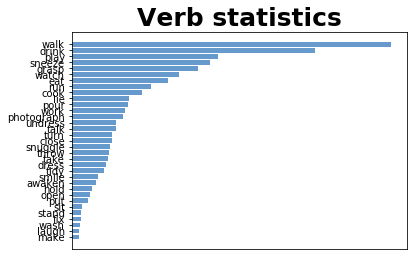

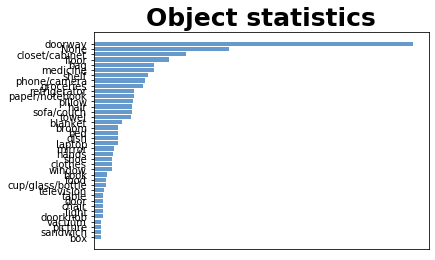

In [47]:
# Verb & Object statistics
import matplotlib.pyplot as plt
action_cnt = {}
verb_cnt = {}
obj_cnt = {}
for vid in data.keys():
    for each_action in data[vid][0]:
        if not action_cnt.__contains__(each_action[0]):
            action_cnt[each_action[0]] = 1
        else:
            action_cnt[each_action[0]] += 1
for each_action in action_cnt.keys():
    if not verb_cnt.__contains__(verb_map[each_action]):
        verb_cnt[verb_map[each_action]] = action_cnt[each_action]
    else:
        verb_cnt[verb_map[each_action]] = action_cnt[each_action]
    if not obj_cnt.__contains__(obj_map[each_action]):
        obj_cnt[obj_map[each_action]] = action_cnt[each_action]
    else:
        obj_cnt[obj_map[each_action]] = action_cnt[each_action]
verb_cnt = sorted(verb_cnt.items(), key=lambda d: d[1], reverse=False)
obj_cnt = sorted(obj_cnt.items(), key=lambda d: d[1], reverse=False)
verb_name = []
verb_num = []
for each in verb_cnt:
    verb_name.append(each[0])
    verb_num.append(each[1])
fig, ax = plt.subplots()
b = ax.barh(range(len(verb_name)), verb_num,## Visualization color='#6699CC')
ax.set_yticks(range(len(verb_name)))
ax.set_yticklabels(verb_name)
plt.xticks(())
plt.title('Verb statistics', loc='center', fontsize='25',
          fontweight='bold')
plt.show()
obj_name = []
obj_num = []
for each in obj_cnt:
    obj_name.append(each[0])
    obj_num.append(each[1])
fig, ax = plt.subplots()
b = ax.barh(range(len(obj_name)), obj_num, color='#6699CC')
ax.set_yticks(range(len(obj_name)))
ax.set_yticklabels(obj_name)
plt.xticks(())
plt.title('Object statistics', loc='center', fontsize='25',
          fontweight='bold')
plt.show()

## Visualization

In [32]:
from knowledge import *
action_start_state = get_global_knowledge(data, fps, frame_object_anno, obj_map, 'start')  # load global knowledge
action_end_state = get_global_knowledge(data, fps, frame_object_anno, obj_map, 'end')## Visualization

In [52]:
from program import *

arg_inp = [['c056', '16.10', '31.80'],]  # input arguments
function_name = 'get_start_states'
video_id = 'SYMIR'

def vis_action_list(action_list):
    for each_action in action_list:
        print(each_action[1] + '-' + each_action[2] + ': ' + mapping[each_action[0]])
        
def vis_action_score_list(action_score_list):
    for i in range(len(action_score_list[0])):
        action = action_score_list[0][i]
        score = action_score_list[1][i]
        print(action[1] + '-' + action[2] + ': ' + mapping[action[0]] + ', ' + str(score)[:5])
        
def vis_rel_cnt(rel_cnt):
    for r in rel_cnt.keys():
        print(r + ": " + str(rel_cnt[r]) + ' time(s)')

def vis_all_actions():
    action_list = all_actions(data, video_id)
    vis_action_list(action_list)
    return action_list

def vis_filter_before(args):
    result = filter_before(args[0], args[1])
    vis_action_list(action_list)
    return result

def vis_filter_after(args):
    result = filter_after(args[0], args[1])
    vis_action_list(action_list)
    return result

def vis_get_start_states(args):
    annotation = anno_video_split[video_id]
    result = get_states(annotation, args[0], fps[video_id+'.mp4'], 'start')
    vis_rel_cnt(result)
    return result

def vis_get_end_states(args):
    annotation = anno_video_split[video_id]
    result = get_states(annotation, args[0], fps[video_id+'.mp4'], 'end')
    vis_rel_cnt(result)
    return result

def vis_filter_start_states(args):
    annotation = anno_video_split[video_id]
    result = filter_states(annotation, fps[video_id+'.mp4'], args[0], args[1], 'start', action_start_state)
    vis_action_score_list(result)
    return result

def vis_filter_end_states(args):
    annotation = anno_video_split[video_id]
    result = filter_states(annotation, fps[video_id+'.mp4'], args[0], args[1], 'end', action_end_state)
    vis_action_score_list(result)
    return result

def vis_relevance(args):
    result = states_relevance(args[0], args[1])
    print("Calculated relevance between two groups of states: " + str(result))
    return result

# supported functional program
strOfFunction = {'all_actions': vis_all_actions, 'filter_before': vis_filter_before, 'filter_after': vis_filter_after,
                 'get_start_states': vis_get_start_states, 'get_end_states': vis_get_end_states,
                 'filter_start_states': vis_filter_start_states, 'filter_end_states': vis_filter_end_states,
                 'relevance': vis_relevance}

In [54]:
# Program visualization
arg_inp = []  # input arguments. Should match the input requirements of corresponding function
function_name = 'all_actions'
_ = strOfFunction[function_name](arg_inp)

12.90-33.00: take off some shoes, 0.047
16.10-31.80: take shoes from somewhere, 0.043
17.70-31.10: throw something on the floor, 0.023


In [56]:
## Video Segment Demo

In [58]:
with open("segment.json", 'r') as f:
    segments = json.load(f)
    
video_id = 'SYMIR'
segment_id = 6
demo_seg = segments[video_id][segment_id]
print("Object:" + demo_seg[0])
print("Time: " + demo_seg[2] + " - " + demo_seg[3])
print("Actions:")
for each_action in demo_seg[1]:
    print('\t' + mapping[each_action])

Object:clothes
Time: 5.30 - 15.30
Actions:
	undress
	take some clothes from somewhere
	hold some clothes
	put clothes somewhere
